# Mar 30, 2025: align partitions
somehow graph-tools isn't working as expected

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
from numba import jit
import arviz as az
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

from scipy.optimize import linear_sum_assignment

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
args.dc, args.sbm = False, 'd'
args.nested = args.sbm == 'h'

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-d'

In [6]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7ff4ddca5d00>

In [7]:
# indiv level estimates
indiv_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes/{SBM}_desc-df.pkl'))
indests_df = []
for indiv_file in tqdm(indiv_files):
    with open(indiv_file, 'rb') as f:
        df = pickle.load(f)
    # sub = [s for s in indiv_file.split('/') if 'sub-' in s][0].split('-')[-1]
    # df['sub'] = [sub] * len(df)
    # df['sbm'] = [SBM] * len(df)
    indests_df += [df]
indests_df = pd.concat(indests_df).reset_index(drop=True)
indests_df

100%|██████████| 9/9 [01:02<00:00,  6.95s/it]


,sub,sbm,mode_id,mode,pi,omega,sigma
0,SLC01,sbm-nd-d,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.438355,0.047416
1,SLC01,sbm-nd-d,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.242659,0.053719
2,SLC01,sbm-nd-d,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.214657,0.039783
3,SLC01,sbm-nd-d,3,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.104328,0.033617
4,SLC03,sbm-nd-d,0,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.000000,0.029646
5,SLC04,sbm-nd-d,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",0.658160,0.064358
6,SLC04,sbm-nd-d,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",0.341840,0.060949
7,SLC05,sbm-nd-d,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.282287,0.054444
8,SLC05,sbm-nd-d,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.254218,0.069755
9,SLC05,sbm-nd-d,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.121791,0.069893


In [8]:
mode = indests_df.iloc[0]['mode']
bs = list(mode.get_nested_partitions().values())
bs[0]

[array([10,  0, 15,  0, 15, 15,  0,  0,  2,  0, 15,  0,  0, 15, 15,  5,  5,
         5,  2,  5,  5,  5,  2,  2,  5,  2,  5, 19,  3, 10,  3, 19, 10, 10,
        14, 12, 12,  2,  2, 11,  5, 16, 16, 17, 17, 12, 17,  3, 12,  6,  6,
         6, 16, 16, 16, 20, 12, 14, 16,  6, 16,  0, 12,  3,  6,  0, 12,  9,
         3, 18, 18,  6,  9,  6,  6, 11, 11, 13, 13, 13, 13, 11, 13, 13, 11,
        18, 17,  0, 15,  0, 14, 14,  0,  0, 14, 14,  0, 20,  1,  7,  7,  7,
         5,  7,  2,  7,  7,  4,  7,  2,  7,  7, 11, 19,  3, 10,  3, 10, 10,
        19, 20,  1,  8,  2,  2, 11,  1,  1,  1, 17, 10,  8, 17,  3,  8,  8,
         8,  8,  1,  4,  1,  1,  1,  1,  1,  8,  1, 20,  9,  3,  8,  0,  9,
         9,  3, 18, 18,  9,  9,  9,  9, 11, 18, 13,  4,  4,  4,  4,  4, 13,
         4,  4], dtype=int32)]

---
sample partitions from each mode

In [9]:
def sample_partitions(args, indests_df):
    all_bs_df = []
    for idx, row in tqdm(indests_df.iterrows()):
        bs = random.sample(
            list(row['mode'].get_partitions().values()), 
            row['num_samples']
        )
        mode_ids = [idx]*len(bs)
        df = pd.DataFrame(dict(
            mode_id=mode_ids,
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

def sample_nested_partitions(args, indests_df):
    all_bs_df = []
    for idx, row in tqdm(indests_df.iterrows()):
        bs = random.sample(
            list(row['mode'].get_nested_partitions().values()), 
            row['num_samples']
        )
        bs = [gt.nested_partition_clear_null(b) for b in bs]
        mode_ids = [idx]*len(bs)
        df = pd.DataFrame(dict(
            mode_id=mode_ids,
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

In [10]:
# sample partitions per mode
args.total_samples = 100
indests_df['num_samples'] = indests_df['omega'].apply(lambda x: np.round(x * args.total_samples).astype(int) if x > 0.01 else 1)
if args.sbm in ['m', 'a', 'd']:
    all_bs_df = sample_partitions(args, indests_df)
if args.sbm in ['h']:
    all_bs_df = sample_nested_partitions(args, indests_df)

33it [00:00, 588.25it/s]


In [11]:
len(all_bs_df)

900

In [12]:
# all_bs_df = all_bs_df.sample(frac=1).reset_index(drop=False)
# all_bs_df = all_bs_df.reset_index(drop=False)

In [13]:
all_bs_df

,mode_id,b
0,0,"[10, 0, 15, 0, 15, 15, 0, 0, 2, 0, 15, 0, 0, 1..."
1,0,"[10, 0, 15, 0, 15, 15, 0, 0, 2, 0, 15, 0, 0, 1..."
2,0,"[10, 0, 20, 0, 15, 15, 0, 0, 2, 0, 15, 0, 0, 1..."
3,0,"[10, 0, 15, 0, 15, 14, 0, 0, 2, 0, 15, 0, 0, 1..."
4,0,"[10, 0, 15, 0, 15, 15, 0, 0, 2, 0, 15, 0, 0, 1..."
...,...,...
895,32,"[19, 0, 17, 0, 17, 17, 0, 0, 4, 0, 0, 14, 14, ..."
896,32,"[19, 0, 17, 0, 17, 1, 0, 0, 1, 0, 0, 14, 14, 1..."
897,32,"[19, 0, 17, 0, 17, 17, 0, 0, 1, 0, 0, 0, 14, 1..."
898,32,"[19, 0, 17, 0, 17, 17, 0, 0, 17, 0, 0, 11, 14,..."


---
scramble group labels so pmode does not get trapped in local subgroup labelings

---
align partitions

In [58]:
bs = all_bs_df['b'].to_list()

In [15]:
len(bs)

900

In [16]:
def extract_community_vectors(bs):
    '''
    from a list of flat partitions
    '''
    df = []
    for idx_b, b in enumerate(bs):
        b = np.array(b)
        B = np.max(b) + 1
        for r in range(B):
            indicator = (b == r).astype(int)
            if np.any(indicator):
                row = {
                    'idx_b': idx_b,
                    'group_label': r,
                    'indicator': indicator,
                }
                df += [row]
    df = pd.DataFrame(df).reset_index(drop=True)
    return df

In [17]:
df = extract_community_vectors(bs)
df

,idx_b,group_label,indicator
0,0,0,"[0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, ..."
1,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,0,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
17023,899,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
17024,899,14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
17025,899,16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
17026,899,17,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


In [18]:
def cluster_group_vectors(df, num_clusters, metric='cosine'):
    X = np.stack(df['indicator'].to_list())

    model = AgglomerativeClustering(
        n_clusters=num_clusters,
        metric=metric,
        linkage='average',
    )
    labels = model.fit_predict(X)

    df['global_label'] = labels
    return df

In [19]:
num_clusters = df['group_label'].max()+1
df = cluster_group_vectors(df, num_clusters=num_clusters)
df

,idx_b,group_label,indicator,global_label
0,0,0,"[0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, ...",5
1,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22
2,0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",12
3,0,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13
4,0,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
...,...,...,...,...
17023,899,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11
17024,899,14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",18
17025,899,16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
17026,899,17,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",15


In [20]:
def compute_cluster_centroids(df):   
    num_nodes = len(df.iloc[0]['indicator'])
    num_clusters = df['global_label'].unique().max()+1
    C = np.zeros((num_nodes, num_clusters))

    for key, group in df.groupby('global_label'):
        ref = np.mean(np.stack(group['indicator'].to_list()), axis=0)
        C[:, key] = ref
    return C

In [21]:
C = compute_cluster_centroids(df)

<Axes: >

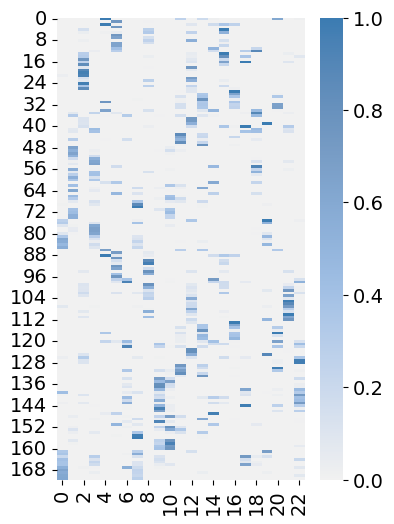

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(4, 6))
ax = axs
sns.heatmap(C, ax=ax, cmap=cc.cm.CET_L12)

In [23]:
def one_hot(b):
    b = np.array(b)
    N = len(b)
    B = np.max(b) + 1
    H = np.zeros((N, B))
    for r in range(B):
        H[:, r] = (b == r).astype(int)
    return H

In [24]:
def align_partition_to_centroids(b, C, metric='cosine'):
    b = np.array(b)

    N = len(b)
    B = np.max(b)+1
    R = C.shape[-1]

    # one-hot of b
    H = one_hot(b)

    D = pairwise_distances(H.T, C.T, metric=metric)
    D.shape

    # Hungarian matching
    row_ind, col_ind = linear_sum_assignment(D)

    # permutation
    perm = np.full(B, fill_value=-1)
    perm[row_ind] = col_ind

    # relabel
    b_aligned = perm[b]
    return b_aligned

In [25]:
bs_aligned = []
for b in tqdm(bs):
    b_aligned = align_partition_to_centroids(b, C)
    bs_aligned.append(b_aligned)

100%|██████████| 900/900 [00:01<00:00, 843.93it/s]


In [26]:
pm = gt.PartitionModeState(bs_aligned, relabel=True, nested=args.nested, converge=False)
bs_aligned = [v for k, v in sorted(pm.get_partitions().items())]

In [27]:
all_bs_df['b_aligned'] = bs_aligned
all_bs_df

,mode_id,b,b_aligned
0,0,"[10, 0, 15, 0, 15, 15, 0, 0, 2, 0, 15, 0, 0, 1...","[0, 1, 2, 1, 2, 2, 1, 1, 3, 1, 2, 1, 1, 2, 2, ..."
1,0,"[10, 0, 15, 0, 15, 15, 0, 0, 2, 0, 15, 0, 0, 1...","[0, 1, 2, 1, 2, 2, 1, 1, 3, 1, 2, 1, 1, 2, 2, ..."
2,0,"[10, 0, 20, 0, 15, 15, 0, 0, 2, 0, 15, 0, 0, 1...","[0, 1, 13, 1, 2, 2, 1, 1, 3, 1, 2, 1, 1, 2, 2,..."
3,0,"[10, 0, 15, 0, 15, 14, 0, 0, 2, 0, 15, 0, 0, 1...","[0, 1, 2, 1, 2, 7, 1, 1, 3, 1, 2, 1, 1, 2, 2, ..."
4,0,"[10, 0, 15, 0, 15, 15, 0, 0, 2, 0, 15, 0, 0, 1...","[0, 1, 2, 1, 2, 2, 1, 1, 3, 1, 2, 1, 1, 2, 2, ..."
...,...,...,...
895,32,"[19, 0, 17, 0, 17, 17, 0, 0, 4, 0, 0, 14, 14, ...","[16, 1, 2, 1, 2, 2, 1, 1, 3, 1, 1, 13, 13, 2, ..."
896,32,"[19, 0, 17, 0, 17, 1, 0, 0, 1, 0, 0, 14, 14, 1...","[16, 1, 2, 1, 2, 7, 1, 1, 7, 1, 1, 13, 13, 2, ..."
897,32,"[19, 0, 17, 0, 17, 17, 0, 0, 1, 0, 0, 0, 14, 1...","[16, 1, 2, 1, 2, 2, 1, 1, 7, 1, 1, 1, 13, 2, 3..."
898,32,"[19, 0, 17, 0, 17, 17, 0, 0, 17, 0, 0, 11, 14,...","[16, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 22, 13, 2, ..."


In [34]:
bs_aligned = all_bs_df['b_aligned'].to_list()
np.random.choice(len(bs_aligned))

351

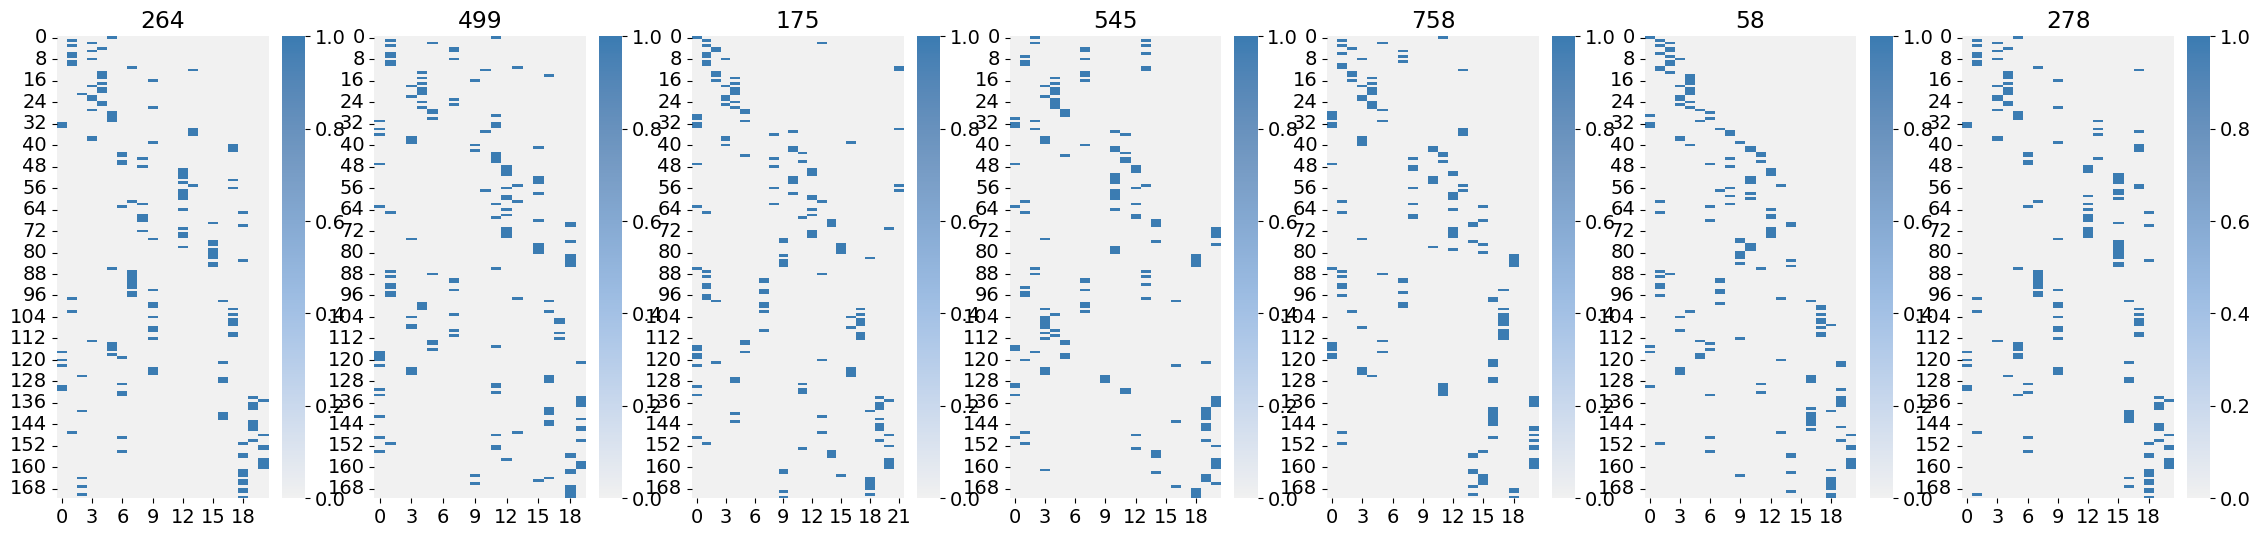

In [66]:
nrows = 1
ncols = 7
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 6*nrows))
for idx in range(ncols):
    ax = axs[idx]
    choice = np.random.choice(len(bs_aligned))
    b = bs_aligned[choice]
    H = one_hot(b)
    sns.heatmap(H, ax=ax, cmap=cc.cm.CET_L12)
    ax.set(title=f'{choice}')

In [49]:
def get_membership_matrix(args, df, col='pi'):
    num_modes = len(df)
    num_comms = np.max(df[col].apply(lambda pi: pi.shape[-1]))
    num_rois = df.iloc[0][col].shape[0]
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode in range(num_modes):
        pi = df.iloc[idx_mode][col]
        M[:, idx_mode, :pi.shape[-1]] = pi
    return M

In [40]:
def get_pi_matrix(args, mrgnls):
    num_comms = np.max([len(mrgnl) for mrgnl in mrgnls])
    pi = np.zeros((len(mrgnls), num_comms))

    for idx_node, mrgnl in enumerate(mrgnls):
        mrgnl = np.array(mrgnl)
        pi[idx_node, np.where(mrgnl)[0]] = mrgnl[mrgnl > 0]

    pi = pi / np.expand_dims(pi.sum(axis=-1), axis=-1)
    return np.round(pi, decimals=3) # marginals matrix
if args.sbm in ['m', 'a', 'd']:
    pis_df = []
    for key, group in tqdm(all_bs_df.groupby(by='mode_id')):
        pm = gt.PartitionModeState(bs=group['b_aligned'], relabel=False, nested=args.nested, converge=False)
        mrgnls = pm.get_marginal(g)
        pi = get_pi_matrix(args, mrgnls)
        df = pd.DataFrame(dict(
            mode_id=[key],
            mode=[pm],
            pi=[pi],
        ))
        pis_df += [df]
        # break
    pis_df = pd.concat(pis_df).reset_index(drop=True)

100%|██████████| 33/33 [00:03<00:00,  9.55it/s]


In [41]:
pis_df

,mode_id,mode,pi
0,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.955, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
1,1,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,3,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,4,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,5,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,..."
6,6,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,..."
7,7,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,8,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,9,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [48]:
# indests_df = indests_df.merge(pis_df, on='mode_id', how='inner', suffixes=['', '_aligned'])
indests_df = pd.concat([indests_df, pis_df.add_suffix('_aligned')], axis=1)
indests_df

,sub,sbm,mode_id,mode,pi,omega,sigma,num_samples,mode_id_aligned,mode_aligned,pi_aligned
0,SLC01,sbm-nd-d,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.438355,0.047416,44,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.955, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
1,SLC01,sbm-nd-d,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.242659,0.053719,24,1,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,SLC01,sbm-nd-d,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.214657,0.039783,21,2,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,SLC01,sbm-nd-d,3,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.104328,0.033617,10,3,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,SLC03,sbm-nd-d,0,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.000000,0.029646,100,4,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,SLC04,sbm-nd-d,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",0.658160,0.064358,66,5,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,..."
6,SLC04,sbm-nd-d,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",0.341840,0.060949,34,6,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,..."
7,SLC05,sbm-nd-d,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.282287,0.054444,28,7,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,SLC05,sbm-nd-d,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.254218,0.069755,25,8,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,SLC05,sbm-nd-d,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.121791,0.069893,12,9,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [50]:
if args.sbm in ['m', 'a', 'd']:
    soft_aligned_df = []
    for sub, group in indests_df.groupby('sub'):
        M = get_membership_matrix(args, group, col=f'pi_aligned')
        omegas = group['omega'].to_list()
        X = np.average(M, axis=1, weights=omegas)
        soft_aligned_df += [pd.DataFrame(dict(
            sub=[sub],
            soft_comm=[X],
        ))]
    soft_aligned_df = pd.concat(soft_aligned_df).reset_index(drop=True)
    display(soft_aligned_df)

if args.sbm in ['h']:
    level = 0
    soft_aligned_df = []
    for sub, group in indests_df.groupby('sub'):
        M = get_membership_matrix(args, group, col=f'pi_{level}')
        omegas = group['omega'].to_list()
        X = np.average(M, axis=1, weights=omegas)
        soft_aligned_df += [pd.DataFrame(dict(
            sub=[sub],
            soft_comm=[X],
        ))]
    soft_aligned_df = pd.concat(soft_aligned_df).reset_index(drop=True)
    display(soft_aligned_df)

,sub,soft_comm
0,SLC01,"[[0.9802740219217537, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,SLC03,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,SLC04,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,..."
3,SLC05,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,SLC06,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,SLC07,"[[0.010018878489720821, 0.0, 0.989981121510279..."
6,SLC08,"[[0.010297511402736657, 0.0, 0.989702488597263..."
7,SLC09,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,SLC10,"[[0.7696630669546436, 0.0, 0.0, 0.0, 0.0, 0.0,..."


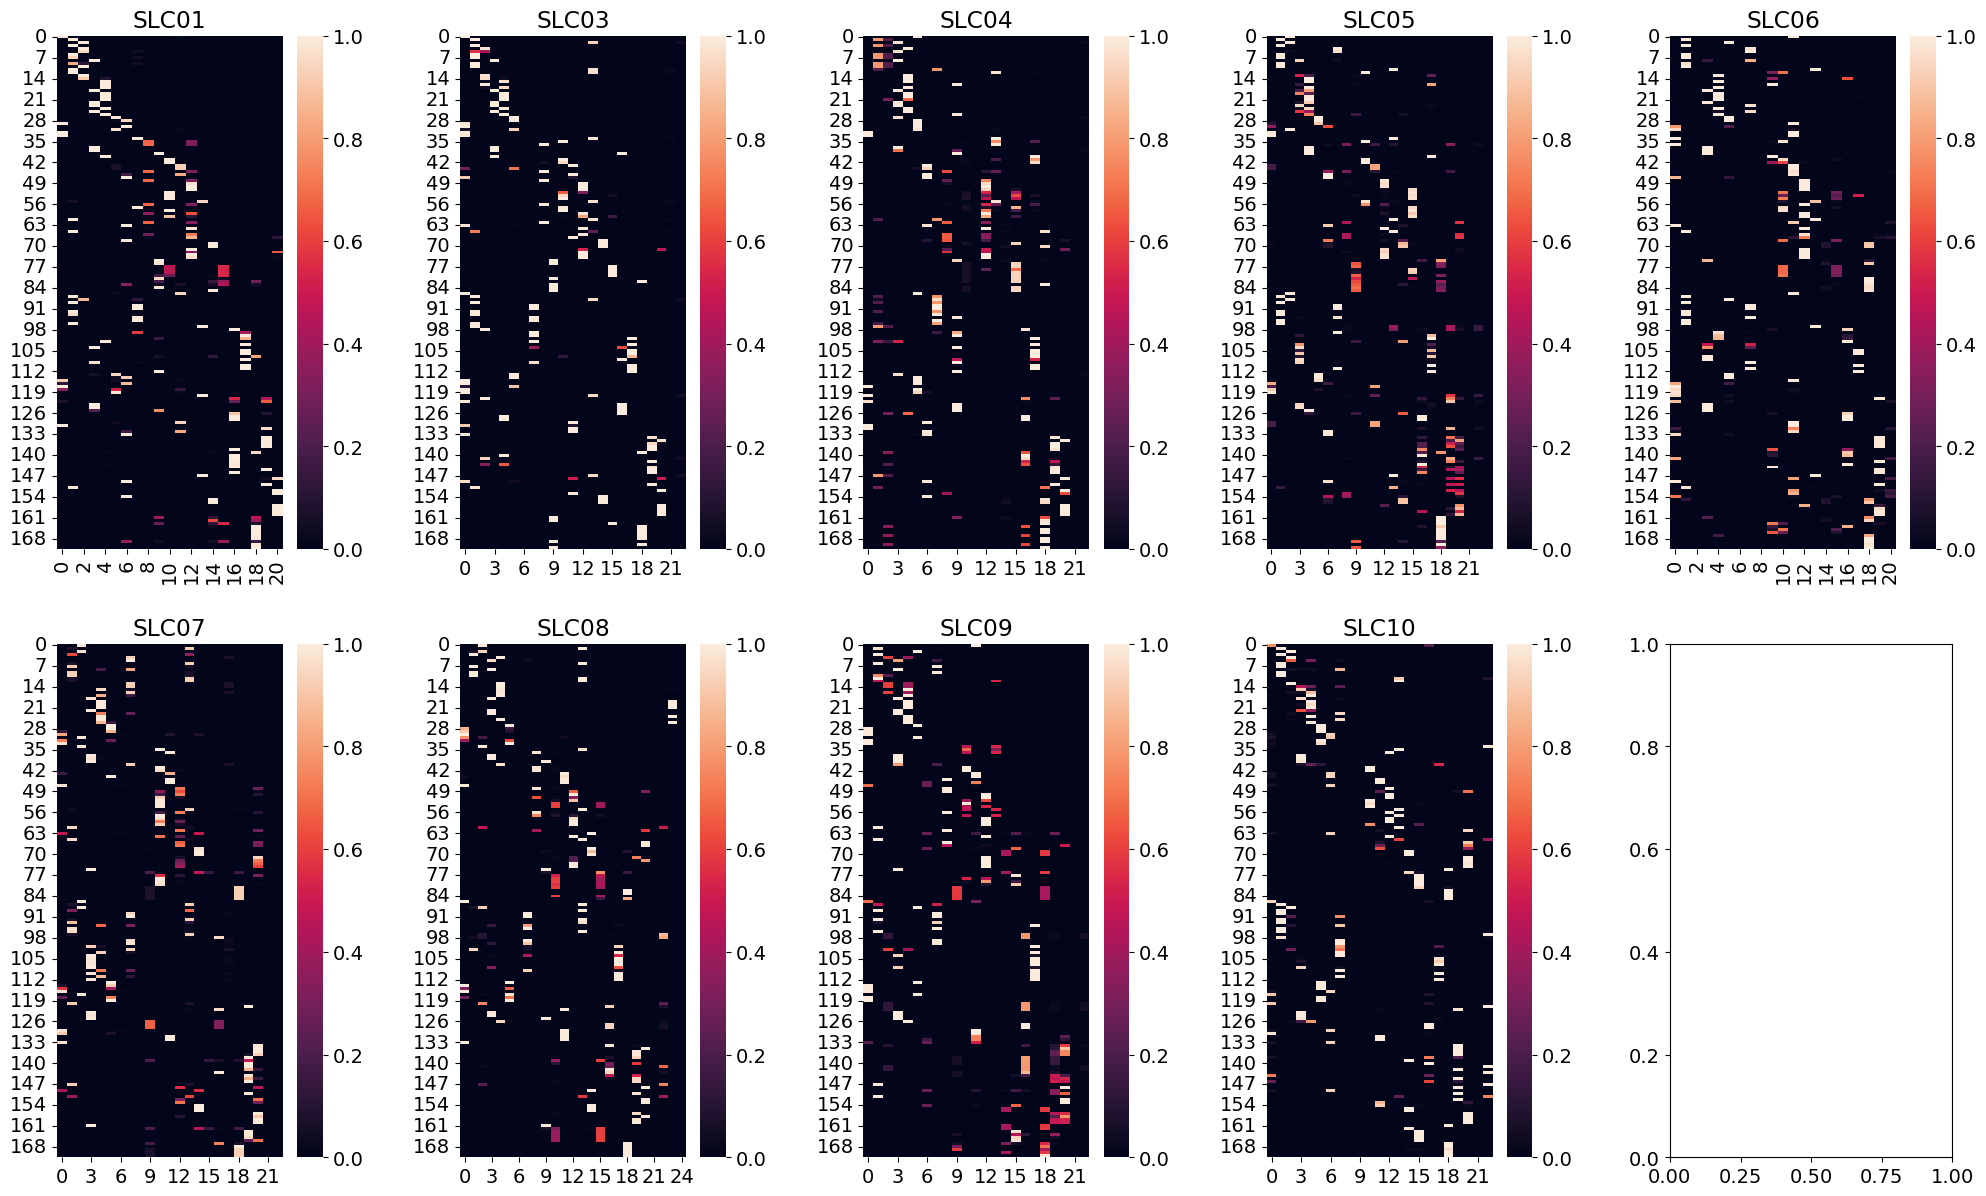

In [51]:
ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, row in soft_aligned_df.iterrows():
    r, c = idx // ncols, idx % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    sns.heatmap(row['soft_comm'], ax=ax)
    ax.set(title=f'{row["sub"]}')

[Text(0.5, 1.0, 'group'),
 Text(0.5, 31.722222222222207, 'comm'),
 Text(15.72222222222222, 0.5, 'roi')]

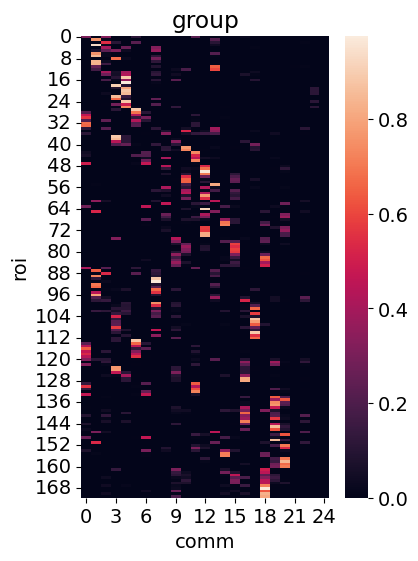

In [52]:
SCsA = get_membership_matrix(args, soft_aligned_df, col='soft_comm') # soft comms aligned
group_soft_comm = np.mean(SCsA, axis=1)

fig, axs = plt.subplots(1, 1, figsize=(4, 6))
ax = axs
sns.heatmap(group_soft_comm, ax=ax)
ax.set(title=f'group', xlabel=f'comm', ylabel=f'roi')

---